In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import glob
import matplotlib.pyplot as plt
import warnings

from utils.conn_data import load_pickle

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [3]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "src", 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [4]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

In [53]:
ticker = "SPY"
etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

etf_df = etf_df.sort_values(by=["date"])
all_scores = []
for fs in etf_df["fs"].unique():
    fs_etf_df = etf_df[etf_df["fs"] == fs]

    score = []
    for i, date in enumerate(fs_etf_df["date"].unique()):
        if i == 0:
            F_t = F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
            s = 0
        else:
            F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
            s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else 0
            F_tm1 = F_t
        score.append({"date": date, "score": s})
    score_df = pd.DataFrame(score)
    score_df["fs"] = fs

    melt_score_df = score_df.melt(["date", "fs"])
    all_scores.append(melt_score_df)
all_scores_df = pd.concat(all_scores).drop("variable", axis=1)

In [62]:
all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False)

,value
fs,
pairwise-granger,0.937309
multivariate-granger,0.921789
lasso,0.882857
var-lingam,0.879023
dynotears,0.782222


<AxesSubplot:xlabel='date'>

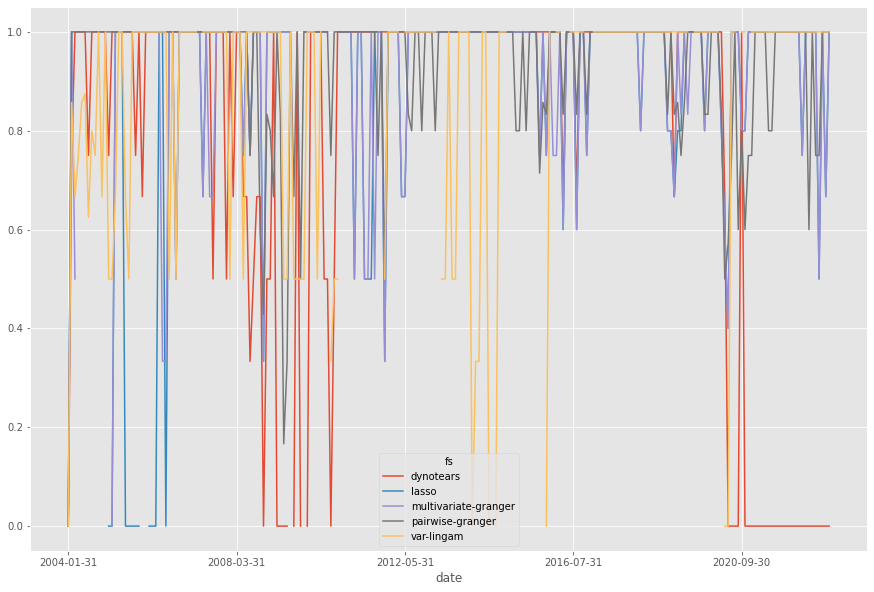

In [60]:
all_scores_df.pivot_table(index="date", columns="fs", values="value").plot(figsize=(15, 10))